In [1]:
import numpy as np
import matplotlib.pyplot as plt
from casadi import *
import cvxpy as cp
from tqdm.notebook import tqdm
%matplotlib notebook

import scipy.linalg

## Defining functions and Jacobian

In [2]:
L = 2.7

def f(x, u):
    # Returns Numpy array
    return np.array([
        u[0] * np.cos(x[2]),
        u[0] * np.sin(x[2]),
        u[0] * np.tan(u[1]) / L
    ])

def fJ(x, u):
    # Returns Casadi object
    return horzcat(
        u[0] * np.cos(x[2]),
        u[0] * np.sin(x[2]),
        u[0] * np.tan(u[1]) / L
    )

# Symbolic Reference point for Linearization
ref = MX.sym('ref', 5)

# Symbolic function for dynamics
F = fJ(ref[:3], ref[3:])

# Symbolic jacobian
J = Function('J', [ref], [jacobian(F, ref)])

## Linearization and Simulation comparison

<ipython-input-3-558a8391454e>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x = np.array([0, 0, 0], dtype=np.float)
<ipython-input-3-558a8391454e>:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  u = np.array([0, 0], np.float)


<ipython-input-3-558a8391454e>:19: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  u = np.array([1, 0.01 * i + np.deg2rad(33.35) * np.cos(3 * i * dt)], np.float)


<IPython.core.display.Javascript object>


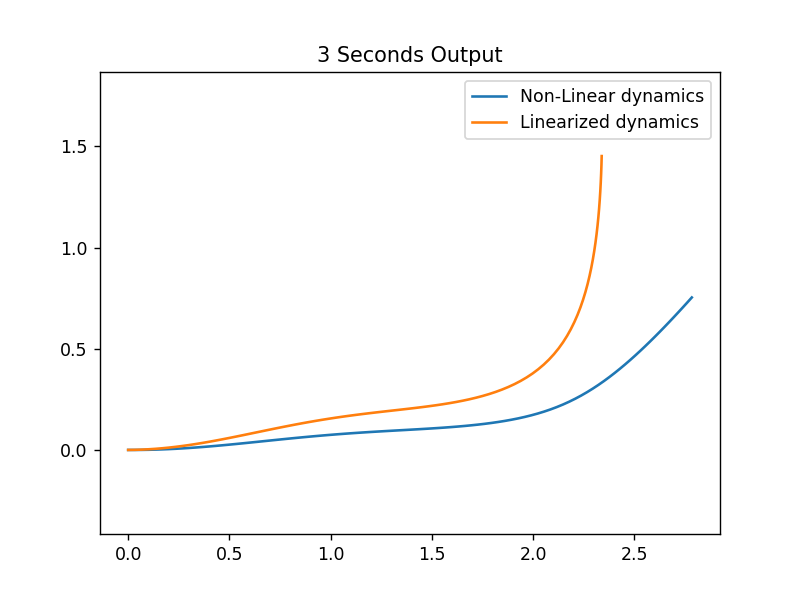

In [3]:
T = 3.0
dt = 0.033333
N = int(T / dt)

x = np.array([0, 0, 0], dtype=np.float)

# Control
u = np.array([0, 0], np.float)

xl = x.copy()

xs = [x.copy()]
xls = [x.copy()]
us = [u.copy()]

for i in tqdm(range(N)):
    
    # Calculating control
    u = np.array([1, 0.01 * i + np.deg2rad(33.35) * np.cos(3 * i * dt)], np.float)
    
    # Non-Linear propagation
    x += np.array(f(x, u)) * dt
    
    # Linearization
    j = np.array(J(np.hstack((x, u))))
    A = j[:, :3]
    B = j[:, 3:]
    
    # Linear Propagation
    xl += (A@x + B@u) * dt
    
    # Appending outputs
    xs.append(x.copy())
    xls.append(xl.copy())
    
xs = np.array(xs)
xls = np.array(xls)

plt.figure()
plt.plot(xs[:, 0], xs[:, 1], label='Non-Linear dynamics')
plt.plot(xls[:, 0], xls[:, 1], label='Linearized dynamics')
plt.axis('equal')
plt.legend(loc='best')
plt.title('3 Seconds Output')
plt.show()

## Defining Bezier Curve

In [4]:
# Defining way-points for reference trajectory
p1 = np.array([0, 0], dtype=np.float)
p2 = np.array([50, 100], dtype=np.float)
p3 = np.array([50, -100], dtype=np.float)
p4 = np.array([100, 0], dtype=np.float)

# Defining functions to create a cubic bezier
def LA(t):
    # Line
    return p1 + (p2 - p1) * t

def LB(t):
    # Line
    return p2 + (p3 - p2) * t

def LC(t):
    # Line
    return p3 + (p4 - p3) * t

def QA(t):
    # Quadratic bezier
    return LA(t) + (LB(t) - LA(t)) * t

def QB(t):
    # Quadratic bezier
    return LB(t) + (LC(t) - LB(t)) * t

def point(t):
    # Cubic bezier
    return QA(t) + (QB(t) - QA(t)) * t

# Perterbation for central difference derivative
pert = 0.0000001

# Distance function
distf = lambda t : np.linalg.norm(coord - point(t))

# Distance function derivative
distfbar = lambda t: (distf(t+pert) - distf(t-pert)) / (2 * pert)

<ipython-input-4-9d9456080cde>:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  p1 = np.array([0, 0], dtype=np.float)
<ipython-input-4-9d9456080cde>:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  p2 = np.array([50, 100], dtype=np.float)
<ipython-input-4-9d9456080cde>:4: DeprecationWarning: `np.float` is a deprecated alias for the builti

## Convex Optimal Control

In [5]:
import os, sys

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

<ipython-input-6-80fea4769118>:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x = np.array([0, 0, 0], dtype=np.float)
<ipython-input-6-80fea4769118>:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  u = np.array([0, 0], np.float)


<ipython-input-6-80fea4769118>:72: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  xref = np.array([rpr[0, 0], rpr[0, 1], x[2], u[0], u[1]], dtype=np.float)


<IPython.core.display.Javascript object>


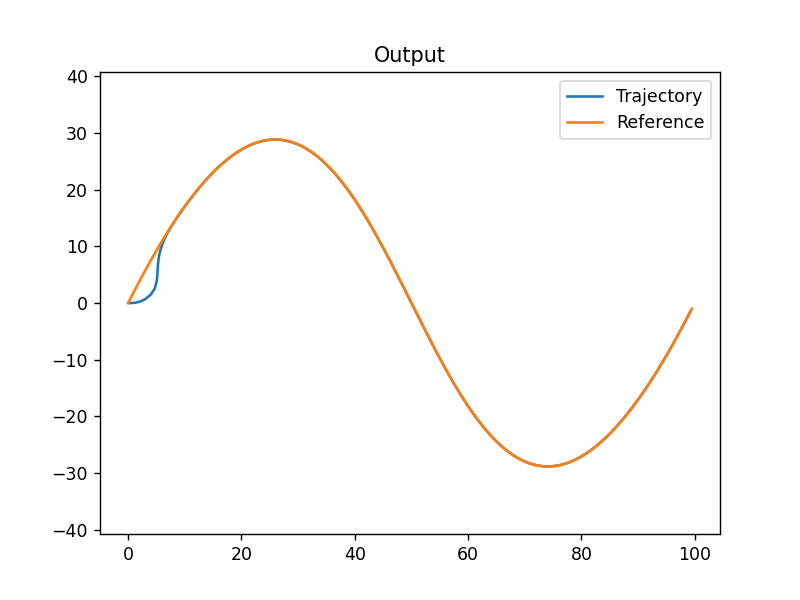

<IPython.core.display.Javascript object>


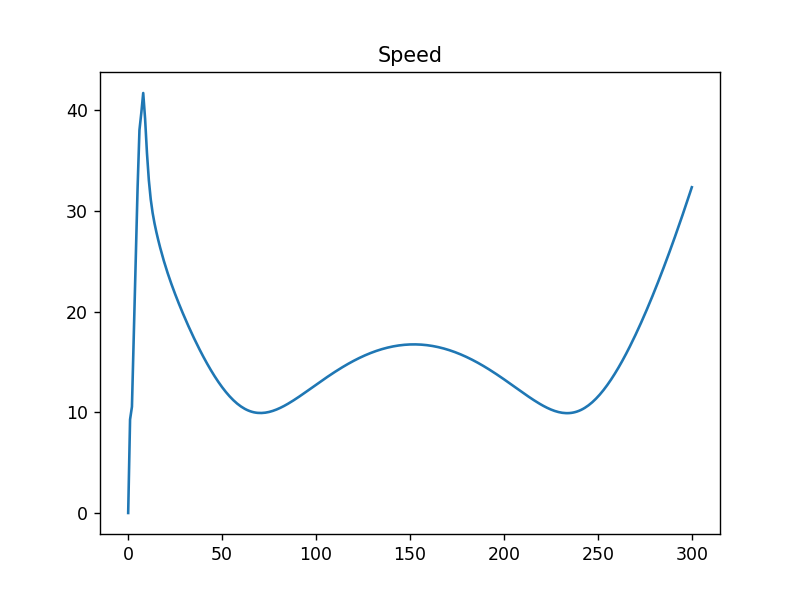

<IPython.core.display.Javascript object>


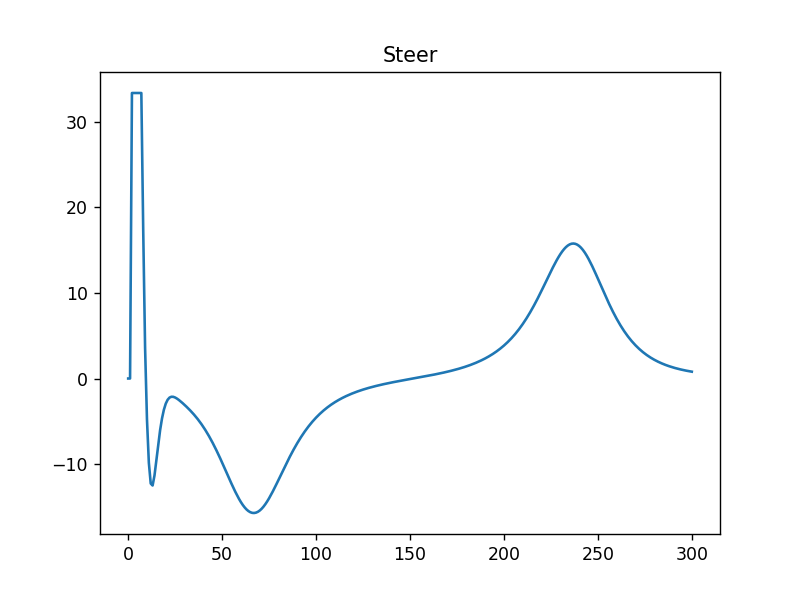

In [6]:
T = 10.0  # Total simulation time
dt = 0.03333 # Time-step
N = int(T / dt) # Simulation steps

# Inital state
x = np.array([0, 0, 0], dtype=np.float)

# Control
u = np.array([0, 0], np.float)

# Registers
xs = [x.copy()]
rps = [point(0)]
us = [u.copy()]

# Weight matrices
Q = np.diag([10, 10, 1])
R = np.diag([.1, .1])

# Defining convex OCP
Tn = 5

opti = Opti()
# Calculating controls through CVXPY
X = opti.variable(Tn+1, 3)
U = opti.variable(1, 2)
rp = opti.parameter(Tn, 2)
refc = opti.parameter(1, 5)
f0 = opti.parameter(1, 3)

Ap = opti.parameter(3, 3)
Bp = opti.parameter(3, 2)

Xi = opti.parameter(1, 3)
opti.set_value(Xi, x)
opti.subject_to(X[0, :] == Xi)
# Direct Multiple shooting formulation
for k in range(Tn):
    opti.subject_to(
        X[k+1, :] == X[k, :] + (f0.T + Ap@(X[k, :] - refc[:3]).T + Bp@(U - refc[3:]).T).T * dt
    ) # close the gaps

# State and control bounds
opti.subject_to(opti.bounded(-30.75, U[0], 77.75))   # track speed limit
opti.subject_to(opti.bounded(-np.deg2rad(33.35), U[1], np.deg2rad(33.35)))   # steering angle limit

loss = sum([(X[k+1, :2] - rp[k, :])@Q[:2,:2]@(X[k+1, :2] - rp[k, :]).T for k in range(Tn)])
loss += U@R@U.T

for i in tqdm(range(N)):
    
    # Deciding xref based on nearest next trajectory point to follow
    coord = x[:2]

    # newton raphson iterations
    t = 0.5
    for _ in range(3):
        foobar = distfbar(t)

        if foobar == 0:
            break

        t = t - distf(t)/foobar
        
    # Waypoint param propagation
    t = [0.00001 + (i+l) * dt / T for l in range(Tn)]
    
    # Reference Point to track
    rpr = np.array([point(t[l]) for l in range(Tn)])

    # Reference point for linearization
    xref = np.array([rpr[0, 0], rpr[0, 1], x[2], u[0], u[1]], dtype=np.float)

    # Linearization
    j = np.array(J(xref))
    
    A = np.array(j[:, :3])
    B = np.array(j[:, 3:])
    
    # Updating the solver params
    opti.set_value(rp, rpr)
    opti.set_value(refc, xref)
    opti.set_value(f0, f(xref[:3], xref[3:]))
    opti.set_value(Ap, A)
    opti.set_value(Bp, B)
    
    # ---- objective          ---------
    opti.minimize(loss)
        
    with HiddenPrints():
        # ---- solve NLP              ------
        solver = opti.solver("ipopt") # set numerical backend
        sol = opti.solve()   # actual solve
    
    # Getting the optimized controls
#     print(problem.status)
    
    u = sol.value(U)
    
    # Applying control to the Non-Linear system
    x += f(x, u) * dt
    
    # sums problem objectives and concatenates constraints.
    opti.set_value(Xi, x)
    
    # Appending outputs
    xs.append(x.copy())
    rps.append(rpr[0, :].copy())
    us.append(u.copy())
    
xs = np.array(xs)
rps = np.array(rps)
us = np.array(us)

# Plotting
plt.figure()
plt.plot(xs[:, 0], xs[:, 1], label='Trajectory')
plt.plot(rps[:, 0], rps[:, 1], label='Reference')
plt.axis('equal')
plt.legend(loc='best')
plt.title('Output')
plt.show()

plt.figure()
plt.plot(us[:, 0])
plt.title('Speed')
plt.show()

plt.figure()
plt.plot(np.rad2deg(us[:, 1]))
plt.title('Steer')
plt.show()